In [53]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from matplotlib.lines import Line2D
from scipy.interpolate import splev, splrep

In [54]:
np.set_printoptions(suppress=True)

In [55]:
def read_pil_csv(h):
    
    df = pd.read_csv("/Users/xumin/ImageProcessing/PIL_output/{}/{}_pil.csv".format(h,h),index_col='Unnamed: 0',parse_dates=True)
    
    return df[df['detection_flag'] != 'no pil SPE']
    
    

In [56]:
def time_series_idx(df):
    
    delta_t = [(j - i)/ np.timedelta64(1,'h') for i,j in zip(df.index[:-1], df.index[1:])]
    
    t_series = np.cumsum(np.array([0] + delta_t))
    
    try:
        
        if len(t_series) == len(df.index):
            
            df['t_series_hr'] = t_series
            
            return df
    
    except:
        
        print("time series length not match to original.")
    
    

In [57]:
def flare_select(df,ar_n):
    
    flare_df = df[(df['noaa_active_region'] == ar_n) & (df['class_level'].isin(['M','X'])) & (df['cme_assoc_conf'] >=3)][['start_time','noaa_active_region','goes_class','class_level','class_numeric']]
    
    
    return flare_df

In [58]:
def flare_pil_searching(df_pil,df_flare):
    
    flare_flag = dict()
    
    for i in df_flare.start_time:
        
        for j in df_pil.index:
            
            if (i > j) and (i <(j + np.timedelta64(12,'m'))):
                
                flare_flag[j] = df_flare[df_flare['start_time']==i]['goes_class'].values[0]
                
                break
    
    
    return flare_flag
                
                

In [138]:
def smooth_pil_series(pil_df,attr,c,lb,smooth_default=200):
    
    #ref: https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.splrep.html#scipy.interpolate.splrep
    #P. Dierckx, “An algorithm for smoothing, differentiation and integration of experimental data using spline functions”, J.Comp.Appl.Maths 1 (1975) 165-184.
    
    x_c = pil_df.t_series_hr
    y_c = pil_df[attr]
    
    spl = splrep(x_c, y_c)

    x2 = np.linspace(0, int(x_c[-1]), smooth_default)
    y2 = splev(x2, spl)
    
    plt.plot(x2, y2, '-',alpha = 0.7,zorder=1,color=c)
    plt.ylabel(lb)
    plt.xlabel("Time / h")
    

In [60]:
#Flare Plot function
# input: pil series, and flare dictionary, attributes,
# output: Scatter plot based on class and size
def plot_flare(pil_df,fl_dir,attr,color):
    
    df_n = pil_df.loc[list(fl_dir.keys())]
    
    x = df_n['t_series_hr']
    
    y = df_n[attr]
    
    m = [list(x)[0] for x in list(fl_dir.values())]
    
    s = [float(''.join(list(x)[1:]))*15 for x in list(fl_dir.values())]
    
    mapping_m = {'M' : '^', 'X': 'x'}
    
    mapping_c = {'M' : 'b', 'X': 'orangered'}

    
    legend_elements = [Line2D([0],[0], marker='^',color='w', label='M-Class-Flares',markerfacecolor='b', markersize=12),
                       Line2D([0],[0], marker='X', color='w', label='X-Class-Flares',markerfacecolor='orangered', markersize=12)]
    
    for i in range(len(x)):
        plt.scatter(x[i], y[i], marker=mapping_m[m[i]],c=mapping_c[m[i]],s= s[i],zorder=2)
    
    
    plt.legend(handles=legend_elements, loc='upper left')

In [61]:
flare_lst = pd.read_csv('fl2cme.csv')
flare_lst['class_level'] = flare_lst['goes_class'].apply(lambda x: list(x)[0])
flare_lst['class_numeric'] = flare_lst['goes_class'].apply(lambda x: float(''.join(list(x)[1:])))
flare_lst['start_time'] = pd.to_datetime(flare_lst['start_time'])

### Eruptive Example: HARP 7115, AR12673

In [62]:
#read PIL meta data file
pil_7115_meta_data = read_pil_csv(7115)

In [63]:
# Turn the timestamp to time interval with unit="hour"
time_series_idx(pil_7115_meta_data)

num_PILs  sum_PIL_length  sum_RoPI_Area  \
2017-08-30 11:12:00       1.0            34.0           64.0   
2017-08-30 11:24:00       1.0            34.0           60.0   
2017-08-30 11:36:00       1.0            38.0           62.0   
2017-08-30 11:48:00       1.0            38.0           55.0   
2017-08-30 12:00:00       1.0            32.0           50.0   
...                       ...             ...            ...   
2017-09-08 03:36:00      14.0           410.0         1313.0   
2017-09-08 03:48:00      13.0           411.0         1334.0   
2017-09-08 04:00:00      12.0           375.0         1240.0   
2017-09-08 04:12:00      14.0           410.0         1369.0   
2017-09-08 04:24:00      14.0           406.0         1411.0   

                     sum_mag_field_strength   fra_dim  \
2017-08-30 11:12:00                  3580.4  0.382881   
2017-08-30 11:24:00                  3495.4  0.347807   
2017-08-30 11:36:00                  3588.5  0.413499   
2017-08-30 11:48:00                  3015.1  0.413499   
2017-08-30 12:00:00                  2666.5  0.366595   
...                                     ...       ...   
2017-09-08 03:36:00                182278.8  0.827841   
2017-09-08 03:48:00                185206.9  0.821603   
2017-09-08 04:00:00                174303.2  0.802639   
2017-09-08 04:12:00                186951.9  0.845773   
2017-09-08 04:24:00                204664.1  0.823271   

                                                    eige_vals  convexity  \
2017-08-30 11:12:00  (0.34766252714905477, 99.61846938015933)   1.731293   
2017-08-30 11:24:00   (0.3708257895642362, 99.38853249920582)   1.648104   
2017-08-30 11:36:00      (0.63440197915304, 123.969438703635)   1.882127   
2017-08-30 11:48:00  (0.6551912694641402, 123.80640190265535)   1.807694   
2017-08-30 12:00:00   (0.5756270990704024, 88.45259870738121)   1.865387   
...                                                       ...        ...   
2017-09-08 03:36:00   (5916.658337255629, 3420.8430402862627)   2.114597   
2017-09-08 03:48:00   (5799.747018858772, 3522.3101765598967)   2.089928   
2017-09-08 04:00:00   (5861.762879509555, 3451.6860474066625)   2.291476   
2017-09-08 04:12:00     (6585.320642276152, 2809.90786866666)   2.136375   
2017-09-08 04:24:00   (6641.167516193973, 3239.3785702865966)   2.161854   

                          Hu1       Hu2       Hu3       Hu4       Hu5  \
2017-08-30 11:12:00  2.853704  8.030735  0.353667  0.040797 -0.004090   
2017-08-30 11:24:00  2.847802  7.989837  0.364277  0.041001 -0.004532   
2017-08-30 11:36:00  3.192758  9.987160  0.796018  0.094059 -0.019972   
2017-08-30 11:48:00  3.189113  9.957411  0.951358  0.109088 -0.030745   
2017-08-30 12:00:00  2.695190  7.077398  0.739739  0.086429 -0.018418   
...                       ...       ...       ...       ...       ...   
2017-09-08 03:36:00  0.728445  0.062940  0.153322  0.200412  0.030351   
2017-09-08 03:48:00  1.123887  0.105314  0.590080  0.516883  0.281559   
2017-09-08 04:00:00  1.014403  0.101952  0.415625  0.438017  0.174072   
2017-09-08 04:12:00  0.839096  0.121679  0.170943  0.346849  0.076751   
2017-09-08 04:24:00  0.962581  0.123431  0.228338  0.455196  0.120534   

                          Hu6       Hu7 patch_shape detection_flag  \
2017-08-30 11:12:00 -0.105311  0.002700  (448, 688)       detected   
2017-08-30 11:24:00 -0.110200  0.002138  (448, 688)       detected   
2017-08-30 11:36:00 -0.266082  0.016233  (448, 688)       detected   
2017-08-30 11:48:00 -0.323167  0.017023  (448, 688)       detected   
2017-08-30 12:00:00 -0.209379  0.011762  (448, 688)       detected   
...                       ...       ...         ...            ...   
2017-09-08 03:36:00  0.042781 -0.017691  (448, 688)       detected   
2017-09-08 03:48:00  0.128818 -0.047027  (448, 688)       detected   
2017-09-08 04:00:00  0.109413 -0.068024  (448, 688)       detected   
2017-09-08 04:12:00  0.104039 -0.035245  (448, 688)       detected   
2017-09

In [64]:
pil_7115_meta_data.fillna(0,inplace=True)

In [65]:
fl_12673 = flare_select(flare_lst,12673)
fl_12673

start_time  noaa_active_region goes_class class_level  \
8451 2017-09-04 18:05:00             12673.0       M1.0           M   
8452 2017-09-04 18:46:00             12673.0       M1.7           M   
8453 2017-09-04 19:59:00             12673.0       M1.5           M   
8454 2017-09-04 20:28:00             12673.0       M5.5           M   
8466 2017-09-05 17:37:00             12673.0       M2.3           M   
8470 2017-09-06 08:57:00             12673.0       X2.2           X   
8471 2017-09-06 11:53:00             12673.0       X9.3           X   
8478 2017-09-07 09:49:00             12673.0       M1.4           M   
8479 2017-09-07 10:11:00             12673.0       M7.3           M   
8481 2017-09-07 14:20:00             12673.0       X1.3           X   
8487 2017-09-07 23:50:00             12673.0       M3.9           M   
8492 2017-09-08 03:39:00             12673.0       M1.2           M   
8497 2017-09-08 07:40:00             12673.0       M8.1           M   
8521 2017-09-09 22:04:00             12673.0       M1.1           M   
8526 2017-09-10 15:35:00             12673.0       X8.2           X   

      class_numeric  
8451            1.0  
8452            1.7  
8453            1.5  
8454            5.5  
8466            2.3  
8470            2.2  
8471            9.3  
8478            1.4  
8479            7.3  
8481            1.3  
8487            3.9  
8492            1.2  
8497            8.1  
8521            1.1  
8526            8.2

In [179]:
len(fl_12673)

15

In [66]:
fl_7115 = flare_pil_searching(pil_7115_meta_data,fl_12673)
fl_7115

{Timestamp('2017-09-04 18:00:00'): 'M1.0',
 Timestamp('2017-09-04 18:36:00'): 'M1.7',
 Timestamp('2017-09-04 19:48:00'): 'M1.5',
 Timestamp('2017-09-04 20:24:00'): 'M5.5',
 Timestamp('2017-09-05 17:36:00'): 'M2.3',
 Timestamp('2017-09-06 08:48:00'): 'X2.2',
 Timestamp('2017-09-06 11:48:00'): 'X9.3',
 Timestamp('2017-09-07 09:48:00'): 'M1.4',
 Timestamp('2017-09-07 10:00:00'): 'M7.3',
 Timestamp('2017-09-07 14:12:00'): 'X1.3',
 Timestamp('2017-09-07 23:48:00'): 'M3.9',
 Timestamp('2017-09-08 03:36:00'): 'M1.2'}

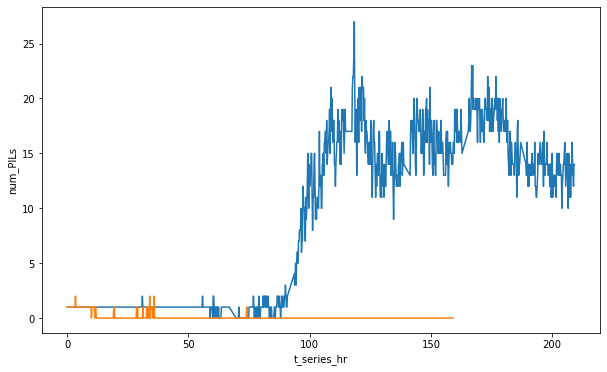

In [67]:
plt.figure(figsize=(10,6))
ax = sns.lineplot(data=pil_7115_meta_data, x=pil_7115_meta_data.t_series_hr,y="num_PILs")
ax2 = sns.lineplot(data=pil_6107_meta_data, x=pil_6107_meta_data.t_series_hr,y="num_PILs")

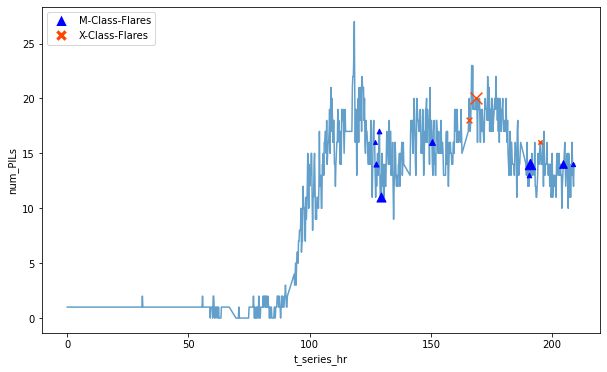

In [68]:

plt.figure(figsize=(10,6))
plot_flare(pil_7115_meta_data,fl_7115,'num_PILs','b')
sns.lineplot(data=pil_7115_meta_data, x=pil_7115_meta_data.t_series_hr,alpha = 0.7,y="num_PILs",zorder=1)


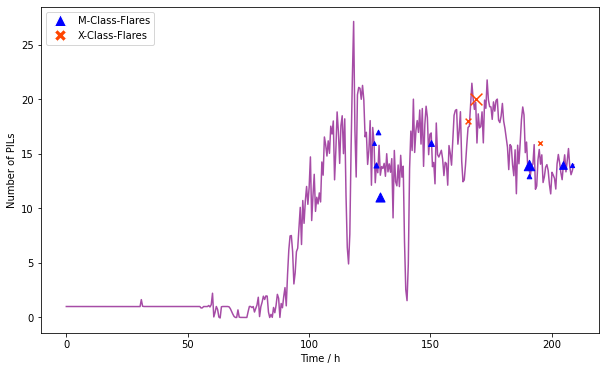

In [139]:
plt.figure(figsize=(10,6))
smooth_pil_series(pil_7115_meta_data,'num_PILs','purple','Number of PILs',smooth_default=400)
plot_flare(pil_7115_meta_data,fl_7115,'num_PILs','b')

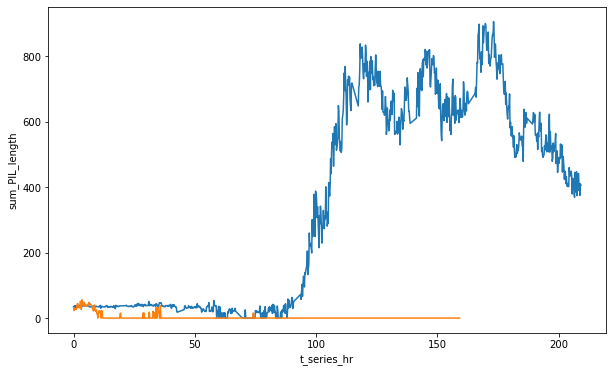

In [140]:
plt.figure(figsize=(10,6))
ax = sns.lineplot(data=pil_7115_meta_data, x=pil_7115_meta_data.t_series_hr,y="sum_PIL_length")
ax2 = sns.lineplot(data=pil_6107_meta_data, x=pil_6107_meta_data.t_series_hr,y="sum_PIL_length")

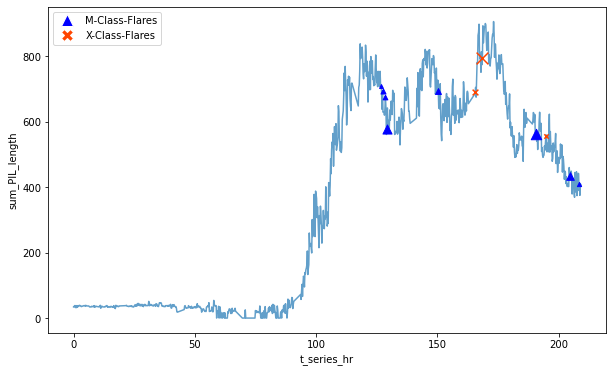

In [141]:
plt.figure(figsize=(10,6))
plot_flare(pil_7115_meta_data,fl_7115,'sum_PIL_length','b')
sns.lineplot(data=pil_7115_meta_data, x=pil_7115_meta_data.t_series_hr,y="sum_PIL_length",alpha = 0.7,zorder=1)

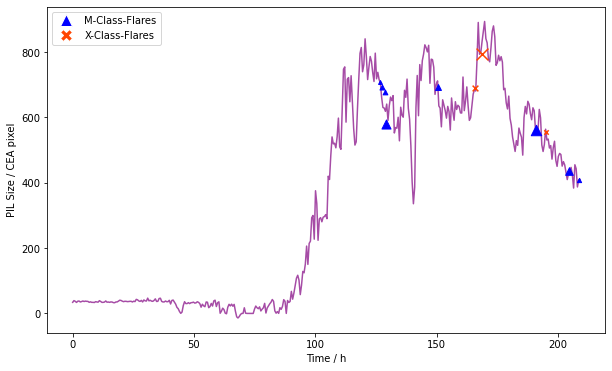

In [142]:
plt.figure(figsize=(10,6))
smooth_pil_series(pil_7115_meta_data,'sum_PIL_length','purple','PIL Size / CEA pixel',smooth_default=400)
plot_flare(pil_7115_meta_data,fl_7115,'sum_PIL_length','b')

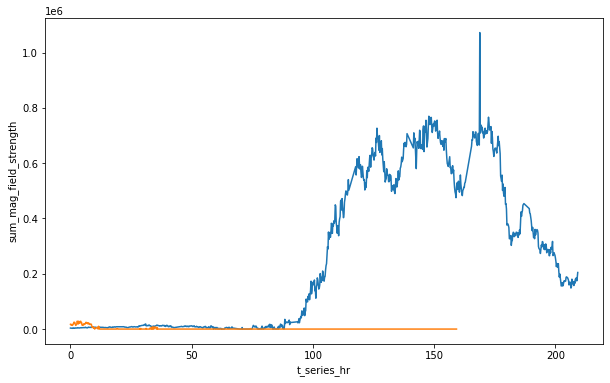

In [143]:
plt.figure(figsize=(10,6))
ax = sns.lineplot(data=pil_7115_meta_data, x=pil_7115_meta_data.t_series_hr,y="sum_mag_field_strength")
ax = sns.lineplot(data=pil_6107_meta_data, x=pil_6107_meta_data.t_series_hr,y="sum_mag_field_strength")

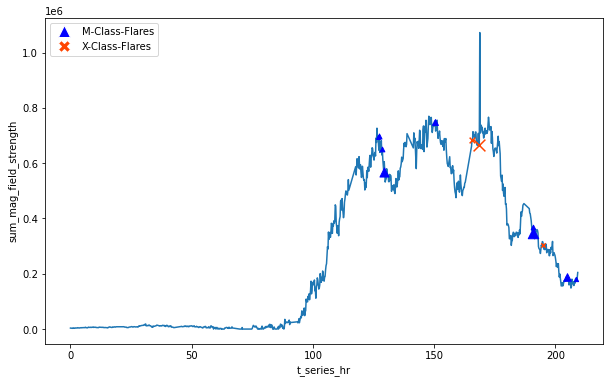

In [144]:
plt.figure(figsize=(10,6))
plot_flare(pil_7115_meta_data,fl_7115,'sum_mag_field_strength','b')
sns.lineplot(data=pil_7115_meta_data, x=pil_7115_meta_data.t_series_hr,y="sum_mag_field_strength",zorder=1)

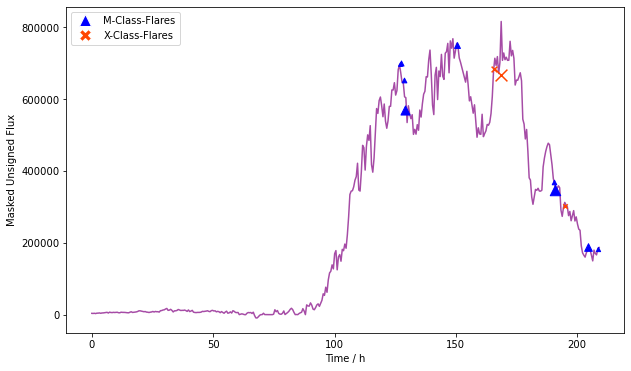

In [145]:
plt.figure(figsize=(10,6))
smooth_pil_series(pil_7115_meta_data,'sum_mag_field_strength','purple','Masked Unsigned Flux',smooth_default=400)
plot_flare(pil_7115_meta_data,fl_7115,'sum_mag_field_strength','b')

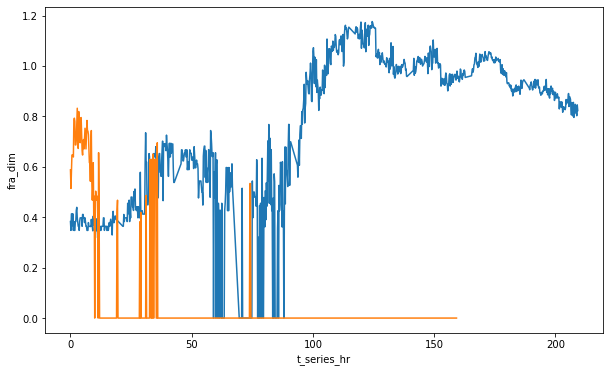

In [146]:
plt.figure(figsize=(10,6))
ax = sns.lineplot(data=pil_7115_meta_data, x=pil_7115_meta_data.t_series_hr,y="fra_dim")
ax = sns.lineplot(data=pil_6107_meta_data, x=pil_6107_meta_data.t_series_hr,y="fra_dim")

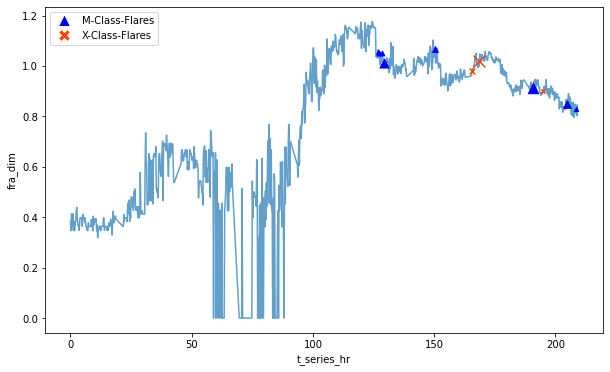

In [147]:
plt.figure(figsize=(10,6))
plot_flare(pil_7115_meta_data,fl_7115,'fra_dim','b')
sns.lineplot(data=pil_7115_meta_data, x=pil_7115_meta_data.t_series_hr,y="fra_dim",zorder=1,alpha = 0.7)

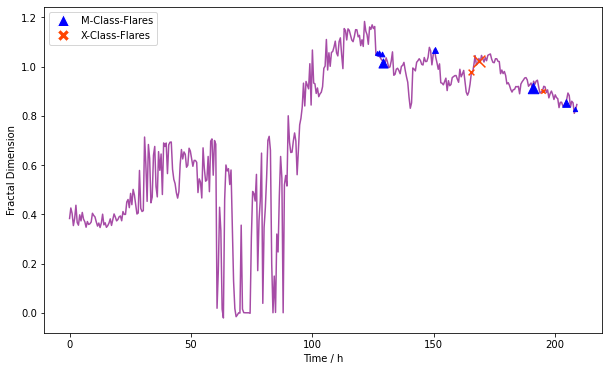

In [148]:
plt.figure(figsize=(10,6))
smooth_pil_series(pil_7115_meta_data,'fra_dim','purple','Fractal Dimension',smooth_default=400)
plot_flare(pil_7115_meta_data,fl_7115,'fra_dim','b')

### Eruptive Example: HARP 377, AR11158

In [149]:
#read PIL meta data file
pil_377_meta_data = read_pil_csv(377)

In [150]:
# Turn the timestamp to time interval with unit="hour"
time_series_idx(pil_377_meta_data)

num_PILs  sum_PIL_length  sum_RoPI_Area  \
2011-02-10 22:00:00       0.0             NaN            NaN   
2011-02-10 22:12:00       0.0             NaN            NaN   
2011-02-10 22:24:00       0.0             NaN            NaN   
2011-02-10 22:36:00       0.0             NaN            NaN   
2011-02-10 22:48:00       0.0             NaN            NaN   
...                       ...             ...            ...   
2011-02-18 09:12:00      10.0           380.0         1121.0   
2011-02-18 09:24:00      10.0           372.0         1195.0   
2011-02-18 09:36:00      12.0           413.0         1288.0   
2011-02-18 09:48:00       9.0           378.0         1155.0   
2011-02-18 10:00:00      11.0           415.0         1267.0   

                     sum_mag_field_strength   fra_dim  \
2011-02-10 22:00:00                     NaN       NaN   
2011-02-10 22:12:00                     NaN       NaN   
2011-02-10 22:24:00                     NaN       NaN   
2011-02-10 22:36:00                     NaN       NaN   
2011-02-10 22:48:00                     NaN       NaN   
...                                     ...       ...   
2011-02-18 09:12:00                173445.8  0.783980   
2011-02-18 09:24:00                184292.1  0.838492   
2011-02-18 09:36:00                184992.5  0.818148   
2011-02-18 09:48:00                171461.1  0.784575   
2011-02-18 10:00:00                176634.1  0.812293   

                                                  eige_vals  convexity  \
2011-02-10 22:00:00                              (nan, nan)        NaN   
2011-02-10 22:12:00                              (nan, nan)        NaN   
2011-02-10 22:24:00                              (nan, nan)        NaN   
2011-02-10 22:36:00                              (nan, nan)        NaN   
2011-02-10 22:48:00                              (nan, nan)        NaN   
...                                                     ...        ...   
2011-02-18 09:12:00  (8403.612430926405, 560.5410408136337)   1.799180   
2011-02-18 09:24:00  (9300.773177973308, 601.5589308288238)   2.029259   
2011-02-18 09:36:00  (8492.496759180154, 570.7854289295848)   1.847178   
2011-02-18 09:48:00  (8784.759476748237, 541.4731731051013)   1.820565   
2011-02-18 10:00:00   (7876.255643238115, 594.129957134388)   1.648853   

                          Hu1       Hu2       Hu3       Hu4       Hu5  \
2011-02-10 22:00:00       NaN       NaN       NaN       NaN       NaN   
2011-02-10 22:12:00       NaN       NaN       NaN       NaN       NaN   
2011-02-10 22:24:00       NaN       NaN       NaN       NaN       NaN   
2011-02-10 22:36:00       NaN       NaN       NaN       NaN       NaN   
2011-02-10 22:48:00       NaN       NaN       NaN       NaN       NaN   
...                       ...       ...       ...       ...       ...   
2011-02-18 09:12:00  1.229252  1.174209  0.165609  0.032870  0.001443   
2011-02-18 09:24:00  1.194762  1.141653  0.032693  0.018948  0.000469   
2011-02-18 09:36:00  1.247156  1.243021  0.196831  0.079452  0.009366   
2011-02-18 09:48:00  1.094546  0.953834  0.031230  0.004760  0.000027   
2011-02-18 10:00:00  0.890143  0.613689  0.102906  0.043712  0.002799   

                          Hu6       Hu7 patch_shape detection_flag  \
2011-02-10 22:00:00       NaN       NaN  (377, 744)     no pil E/W   
2011-02-10 22:12:00       NaN       NaN  (377, 744)     no pil E/W   
2011-02-10 22:24:00       NaN       NaN  (377, 744)     no pil E/W   
2011-02-10 22:36:00       NaN       NaN  (377, 744)     no pil E/W   
2011-02-10 22:48:00       NaN       NaN  (377, 744)     no pil E/W   
...                       ...       ...         ...            ...   
2011-02-18 09:12:00  0.017269 -0.001949  (377, 744)       detected   
2011-02-18 09:24:00  0.009274 -0.000050  (377, 744)       detected   
2011-02-18 09:36:00  0.075459 -0.003317  (377, 744)       detected   
2011-02-18 09:48:00 -0.002407  0.000051  (377, 744)       detected   
2011-02-18 10:00:00  0.031126 -

In [151]:
pil_377_meta_data.fillna(0,inplace=True)

In [152]:
fl_11158 = flare_select(flare_lst,11158)
fl_11158

start_time  noaa_active_region goes_class class_level  \
143 2011-02-13 17:28:00             11158.0       M6.6           M   
153 2011-02-14 17:20:00             11158.0       M2.2           M   
158 2011-02-15 01:44:00             11158.0       X2.2           X   

     class_numeric  
143            6.6  
153            2.2  
158            2.2

In [153]:
fl_377 = flare_pil_searching(pil_377_meta_data,fl_11158)
fl_377

{Timestamp('2011-02-13 17:24:00'): 'M6.6',
 Timestamp('2011-02-14 17:12:00'): 'M2.2',
 Timestamp('2011-02-15 01:36:00'): 'X2.2'}

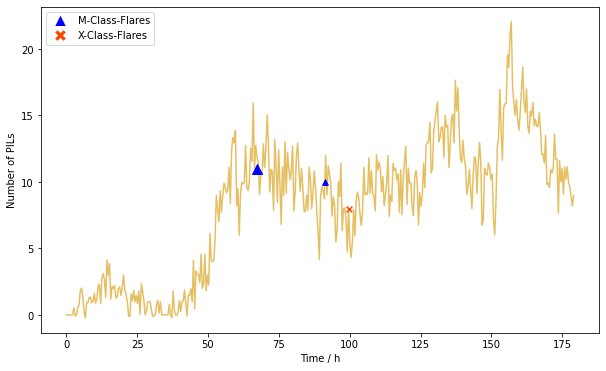

In [154]:
plt.figure(figsize=(10,6))
smooth_pil_series(pil_377_meta_data,'num_PILs',"goldenrod","Number of PILs",smooth_default=400)
plot_flare(pil_377_meta_data,fl_377,'num_PILs','b')

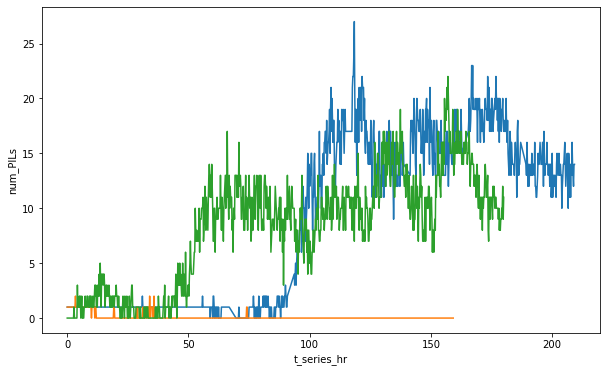

In [155]:
plt.figure(figsize=(10,6))
ax = sns.lineplot(data=pil_7115_meta_data, x=pil_7115_meta_data.t_series_hr,y="num_PILs")
ax2 = sns.lineplot(data=pil_6107_meta_data, x=pil_6107_meta_data.t_series_hr,y="num_PILs")
ax = sns.lineplot(data=pil_377_meta_data, x=pil_377_meta_data.t_series_hr,y="num_PILs")

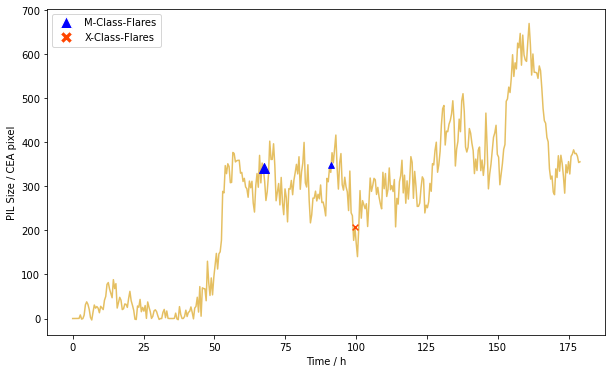

In [156]:
plt.figure(figsize=(10,6))
smooth_pil_series(pil_377_meta_data,'sum_PIL_length','goldenrod',"PIL Size / CEA pixel",smooth_default=400)
plot_flare(pil_377_meta_data,fl_377,'sum_PIL_length','b')

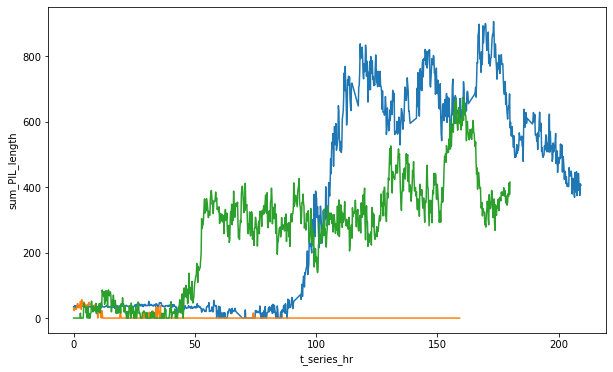

In [157]:
plt.figure(figsize=(10,6))
ax = sns.lineplot(data=pil_7115_meta_data, x=pil_7115_meta_data.t_series_hr,y="sum_PIL_length")
ax2 = sns.lineplot(data=pil_6107_meta_data, x=pil_6107_meta_data.t_series_hr,y="sum_PIL_length")
ax3 = sns.lineplot(data=pil_377_meta_data, x=pil_377_meta_data.t_series_hr,y="sum_PIL_length")

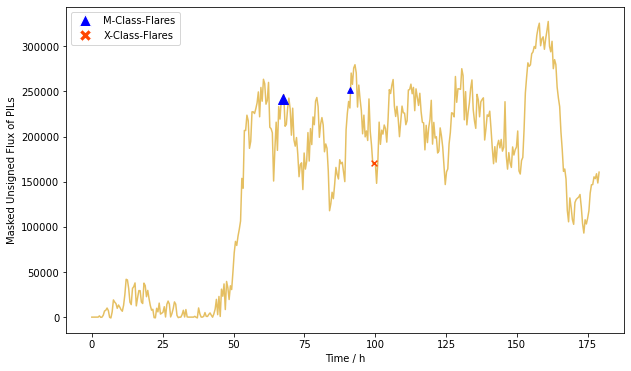

In [158]:
plt.figure(figsize=(10,6))
smooth_pil_series(pil_377_meta_data,'sum_mag_field_strength','goldenrod',"Masked Unsigned Flux of PILs",smooth_default=400)
plot_flare(pil_377_meta_data,fl_377,'sum_mag_field_strength','b')

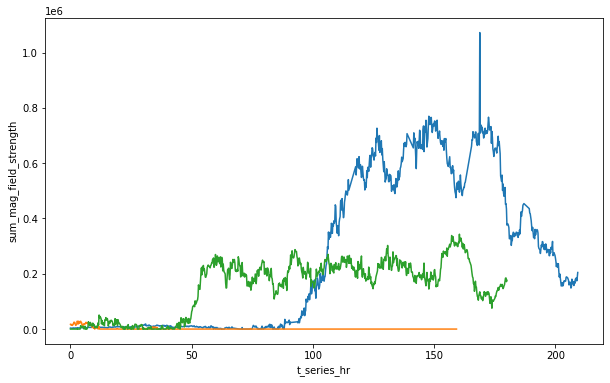

In [159]:
plt.figure(figsize=(10,6))
ax = sns.lineplot(data=pil_7115_meta_data, x=pil_7115_meta_data.t_series_hr,y="sum_mag_field_strength")
ax = sns.lineplot(data=pil_6107_meta_data, x=pil_6107_meta_data.t_series_hr,y="sum_mag_field_strength")
ax3 = sns.lineplot(data=pil_377_meta_data, x=pil_377_meta_data.t_series_hr,y="sum_mag_field_strength")

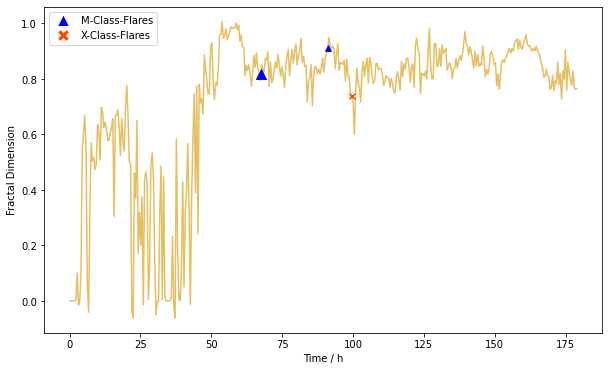

In [160]:
plt.figure(figsize=(10,6))
smooth_pil_series(pil_377_meta_data,'fra_dim','goldenrod',"Fractal Dimension",smooth_default=400)
plot_flare(pil_377_meta_data,fl_377,'fra_dim','b')

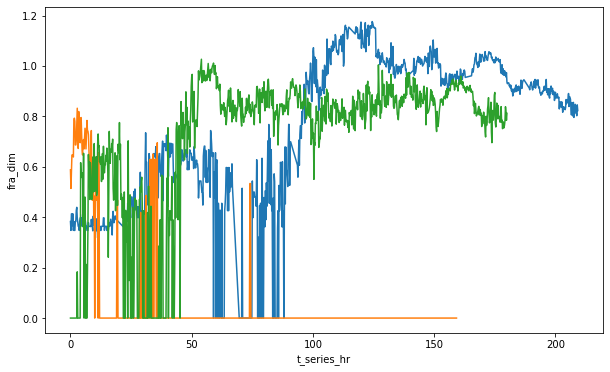

In [161]:
plt.figure(figsize=(10,6))
ax = sns.lineplot(data=pil_7115_meta_data, x=pil_7115_meta_data.t_series_hr,y="fra_dim")
ax = sns.lineplot(data=pil_6107_meta_data, x=pil_6107_meta_data.t_series_hr,y="fra_dim")
ax3 = sns.lineplot(data=pil_377_meta_data, x=pil_377_meta_data.t_series_hr,y="fra_dim")

In [162]:
# x_c = pil_7115_meta_data.t_series_hr
# y_c = pil_7115_meta_data['sum_mag_field_strength']



# spl = splrep(x_c, y_c)

# x2 = np.linspace(0, 200, 200)
# y2 = splev(x2, spl)

# # f_cubic = interp1d(x_c, y_c, kind='cubic')
# plt.plot(x2, y2, '-', label='cubic')

In [164]:
# smooth_pil_series(pil_7115_meta_data,'sum_mag_field_strength',c='b',smooth_default=100)

In [165]:
# x=[1,2,3,4,5,6]
# y=[1,3,4,5,6,7]
# m=['k','l','l','k','j','l']

# mapping = {'j' : 'o', 'k': 'x', 'l': '+'}

# for i in range(len(x)):
#     plt.scatter(x[i], y[i], marker=mapping[m[i]])

### Non-Eruptive Example: HARP 6107, AR12455

In [166]:
#read PIL meta data file
pil_6107_meta_data = read_pil_csv(6107)

In [167]:
# Turn the timestamp to time interval with unit="hour"
time_series_idx(pil_6107_meta_data)

num_PILs  sum_PIL_length  sum_RoPI_Area  \
2015-11-14 10:48:00         1            31.0          119.0   
2015-11-14 11:00:00         1            23.0          106.0   
2015-11-14 11:12:00         1            26.0          120.0   
2015-11-14 11:24:00         1            29.0          127.0   
2015-11-14 11:36:00         1            29.0          116.0   
...                       ...             ...            ...   
2015-11-21 01:12:00         0             NaN            NaN   
2015-11-21 01:24:00         0             NaN            NaN   
2015-11-21 01:36:00         0             NaN            NaN   
2015-11-21 01:48:00         0             NaN            NaN   
2015-11-21 02:00:00         0             NaN            NaN   

                     sum_mag_field_strength   fra_dim  \
2015-11-14 10:48:00                 17266.4  0.587869   
2015-11-14 11:00:00                 14718.3  0.514286   
2015-11-14 11:12:00                 15029.3  0.587869   
2015-11-14 11:24:00                 17284.7  0.646772   
2015-11-14 11:36:00                 13172.7  0.646772   
...                                     ...       ...   
2015-11-21 01:12:00                     NaN       NaN   
2015-11-21 01:24:00                     NaN       NaN   
2015-11-21 01:36:00                     NaN       NaN   
2015-11-21 01:48:00                     NaN       NaN   
2015-11-21 02:00:00                     NaN       NaN   

                                                   eige_vals  convexity  \
2015-11-14 10:48:00  (19.248137943139422, 37.15616313212939)   1.716555   
2015-11-14 11:00:00   (3.645000277785055, 45.78187719257069)   2.037829   
2015-11-14 11:12:00   (4.271308020861724, 67.10715351759983)   2.137017   
2015-11-14 11:24:00   (5.955501276751761, 70.13316867398714)   2.075302   
2015-11-14 11:36:00  (3.6146284689383634, 89.94448483155426)   2.256083   
...                                                      ...        ...   
2015-11-21 01:12:00                               (nan, nan)        NaN   
2015-11-21 01:24:00                               (nan, nan)        NaN   
2015-11-21 01:36:00                               (nan, nan)        NaN   
2015-11-21 01:48:00                               (nan, nan)        NaN   
2015-11-21 02:00:00                               (nan, nan)        NaN   

                          Hu1       Hu2       Hu3       Hu4       Hu5  \
2015-11-14 10:48:00  1.760800  0.312530  3.057011  0.640156 -0.073155   
2015-11-14 11:00:00  1.027780  0.767713  0.317131  0.074413  0.004595   
2015-11-14 11:12:00  1.319868  1.350024  0.582189  0.167525  0.036989   
2015-11-14 11:24:00  1.266637  1.141384  0.612349  0.137382  0.018255   
2015-11-14 11:36:00  1.557464  2.065314  0.673254  0.223267  0.073647   
...                       ...       ...       ...       ...       ...   
2015-11-21 01:12:00       NaN       NaN       NaN       NaN       NaN   
2015-11-21 01:24:00       NaN       NaN       NaN       NaN       NaN   
2015-11-21 01:36:00       NaN       NaN       NaN       NaN       NaN   
2015-11-21 01:48:00       NaN       NaN       NaN       NaN       NaN   
2015-11-21 02:00:00       NaN       NaN       NaN       NaN       NaN   

                          Hu6       Hu7 patch_shape detection_flag  \
2015-11-14 10:48:00 -0.052783  0.892531  (158, 309)       detected   
2015-11-14 11:00:00  0.009015  0.010467  (158, 309)       detected   
2015-11-14 11:12:00  0.099998  0.037000  (158, 309)       detected   
2015-11-14 11:24:00  0.046789  0.035420  (158, 309)       detected   
2015-11-14 11:36:00  0.225895  0.045487  (158, 309)       detected   
...                       ...       ...         ...            ...   
2015-11-21 01:12:00       NaN       NaN  (158, 309)     no pil E/W   
2015-11-21 01:24:00       NaN       NaN  (158, 309)     no pil E/W   
2015-11-21 01:36:00       NaN       NaN  (158, 309)     no pil E/W   
2015-11-21 01:48:00       NaN       NaN  (158, 309)     no pil E/W   
2015-11-21 02:00:00

In [168]:
pil_6107_meta_data.fillna(0,inplace=True)

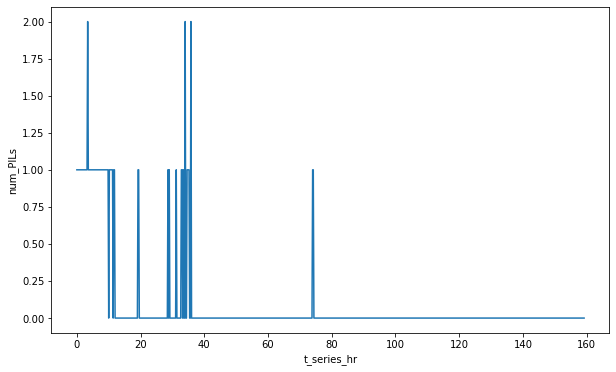

In [169]:
plt.figure(figsize=(10,6))
ax = sns.lineplot(data=pil_6107_meta_data, x=pil_6107_meta_data.t_series_hr,y="num_PILs")

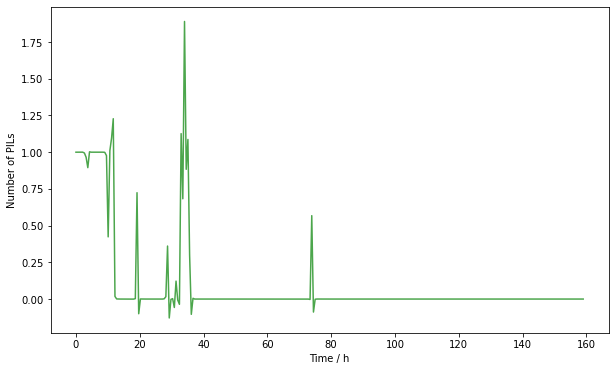

In [185]:
plt.figure(figsize=(10,6))
smooth_pil_series(pil_6107_meta_data,'num_PILs','green','Number of PILs',smooth_default=300)

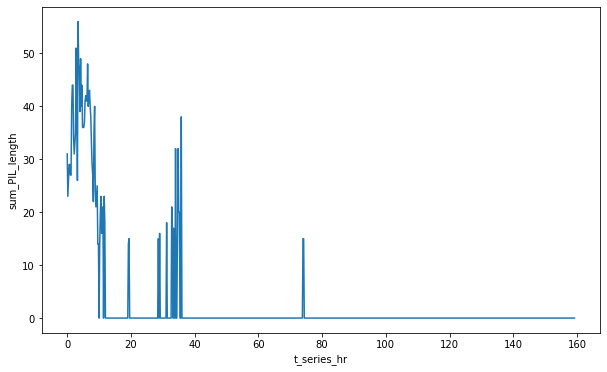

In [171]:
plt.figure(figsize=(10,6))
ax2 = sns.lineplot(data=pil_6107_meta_data, x=pil_6107_meta_data.t_series_hr,y="sum_PIL_length")

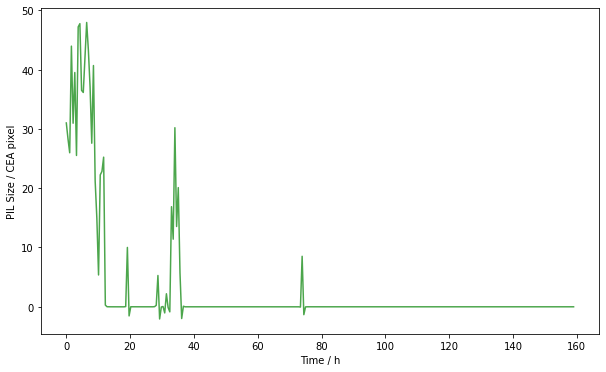

In [172]:
plt.figure(figsize=(10,6))
smooth_pil_series(pil_6107_meta_data,'sum_PIL_length','green','PIL Size / CEA pixel',smooth_default=300)

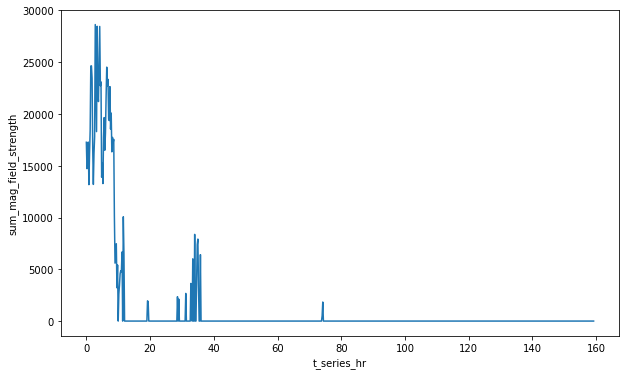

In [173]:
plt.figure(figsize=(10,6))
ax2 = sns.lineplot(data=pil_6107_meta_data, x=pil_6107_meta_data.t_series_hr,y="sum_mag_field_strength")

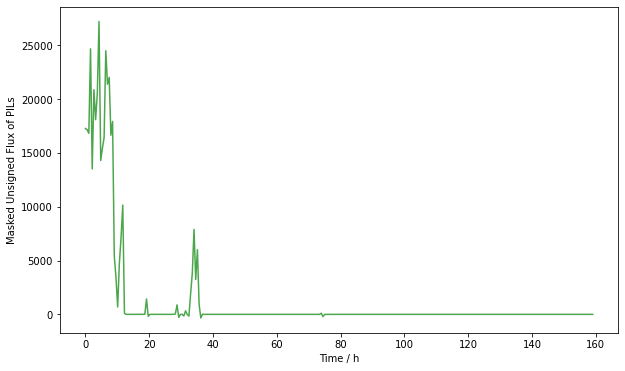

In [174]:
plt.figure(figsize=(10,6))
smooth_pil_series(pil_6107_meta_data,'sum_mag_field_strength','green','Masked Unsigned Flux of PILs',smooth_default=300)

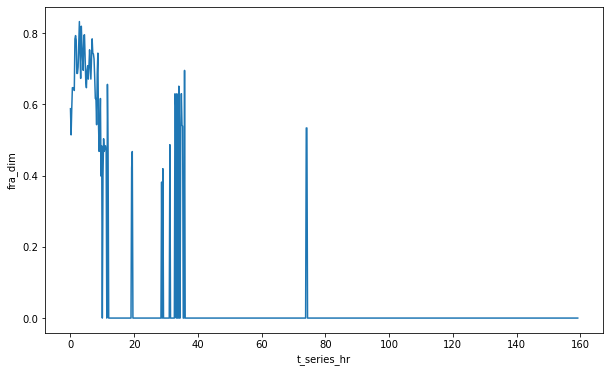

In [175]:
plt.figure(figsize=(10,6))
ax2 = sns.lineplot(data=pil_6107_meta_data, x=pil_6107_meta_data.t_series_hr,y="fra_dim")

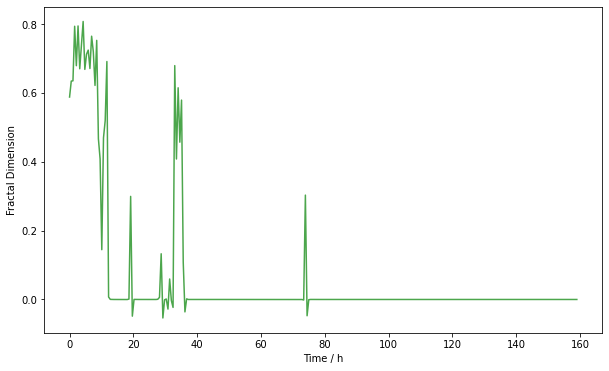

In [176]:
plt.figure(figsize=(10,6))
smooth_pil_series(pil_6107_meta_data,'fra_dim','green','Fractal Dimension',smooth_default=300)

In [178]:
# plt.figure(figsize=(10,6))
# smooth_pil_series(pil_6107_meta_data,'fra_dim','orange',smooth_default=200)
# smooth_pil_series(pil_7115_meta_data,'fra_dim',c='b',smooth_default=400)
# plot_flare(pil_7115_meta_data,fl_7115,'fra_dim','b')
# smooth_pil_series(pil_377_meta_data,'fra_dim','g',smooth_default=400)
# plot_flare(pil_377_meta_data,fl_377,'fra_dim','b')